# 2. Reuters 딥러닝 모델
- 시퀀스 데이터(텍스트)를 받아서 분류
- Reuters 데이터셋을 이용해 텍스트로 구성된 뉴스 데이터의 주제를 분류

## 데이터 로드
- keras.datasets의 reuters 데이터셋을 사용
- 단어 개수는 10000개로 제한

In [2]:
# 필요 라이브러리 로드
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [3]:
# 데이터 불러오기
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [4]:
# 단어 인덱스를 단어로 변환
word_index = reuters.get_word_index()

# {word:index} -> {index:word}
index_word = dict([(value, key) for (key, value) in word_index.items()])

In [5]:
# index_word 구경
import itertools
dict(itertools.islice(index_word.items(), 10))

{10996: 'mdbl',
 16260: 'fawc',
 12089: 'degussa',
 8803: 'woods',
 13796: 'hanging',
 20672: 'localized',
 20673: 'sation',
 20675: 'chanthaburi',
 10997: 'refunding',
 8804: 'hermann'}

- 단어 인덱스에서 0, 1, 2는 아래와 같이 지정됨
  - 0 : 패딩 토큰 `pad`,
  - 1 : 문장의 시작 토큰 `sos`
  - 2 : OOV(Out Of Vocabulary) 토큰 `unk`
그래서 인덱스는 i-3으로 맞추고, 위 토큰들은 `?`로 대체함

---
> dictionary.get(keyname, value)
- Parameter 
    - keyname	: Required. The keyname of the item you want to return the value from
    - value :	Optional. A value to return if the specified key does not exist.
        - Default value None

In [6]:
# 하나의 리뷰 생성하고싶으면 : 예) train_data[3]의 각 인덱스에 매핑되는 단어들을 연결
news = ' '.join([str(i) for i in train_data[3]])
news = ' '.join([index_word.get(i-3, '?') for i in train_data[3]])
news

"? the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely ? borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in ? financial eligibility standards indicated as many as one half of ? borrowers who received new loans from the agency in 1986 would be ? under the proposed system the agency has proposed evaluating ? credit using a variety of financial ratios instead of relying solely on ? ability senate agriculture committee chairman patrick leahy d vt ? the proposed eligibility changes telling ? administrator ? clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' lender of last resort toward becoming a big city bank but

In [7]:
# 데이터 분리 : 검증데이터 25%
# (train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels,
                                                    test_size=0.25, random_state=42, shuffle=True)

print("train_data :", len(train_data))
print("valdata :", len(val_data))
print("test_data :", len(test_data))
print("train_labels :",  len(set(train_labels)))

train_data : 6736
valdata : 2246
test_data : 2246
train_labels : 46


- 분류할 label 개수는 총 46개!

## Preprocessing
- 텍스트 데이터 : 원핫인코딩
- 레이블 데이터(뉴스 카테고리) : 범주형 데이터 전처리 to_categorical()

In [8]:
# one-hot encoing
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# news labels : categorical nomalization
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

In [9]:
# 전처리 확인
x_train[0], y_train[0]

(array([0., 1., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

## 모델 구성 및 컴파일
- BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지
- 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성

- 노드 결과는 과대적합이라 모델을 수정해보면서 학습시켜볼 예정
    - dropout 비중 30% -> 50%
    - 가중치초기화 추가 : He initializer / Orthogonal initializer
    - Regularization : L1, L2

In [30]:
from keras import optimizers
# model1
'''
dropout: 50%
he_uniform initializer
batch normalization
Adam - learning rate : 0.001
'''
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000,), kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, kernel_initializer='he_uniform'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# model configure & summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               1280128   
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                     

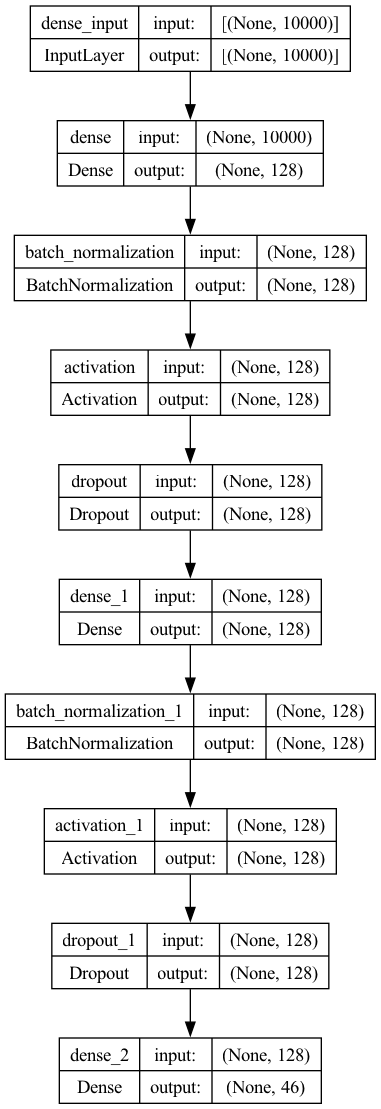

In [11]:
utils.plot_model(model, show_shapes=True)

## 모델 학습

In [31]:
# ModelCheckpoint
check_point_cb = callbacks.ModelCheckpoint('project_reuters_model.keras', save_best_only=True)

# EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# train
history = model.fit(x_train, y_train, epochs=60, 
                    validation_data=(x_val, y_val), callbacks=[check_point_cb, early_stop])

Epoch 1/60
211/211 [==============================] - 1s 4ms/step - loss: 1.9569 - accuracy: 0.5533 - val_loss: 1.4813 - val_accuracy: 0.7182
Epoch 2/60
211/211 [==============================] - 1s 3ms/step - loss: 1.2811 - accuracy: 0.7015 - val_loss: 1.1041 - val_accuracy: 0.7609
Epoch 3/60
211/211 [==============================] - 1s 3ms/step - loss: 1.0398 - accuracy: 0.7533 - val_loss: 1.0205 - val_accuracy: 0.7823
Epoch 4/60
211/211 [==============================] - 1s 3ms/step - loss: 0.8800 - accuracy: 0.7847 - val_loss: 0.9722 - val_accuracy: 0.7934
Epoch 5/60
211/211 [==============================] - 1s 3ms/step - loss: 0.7459 - accuracy: 0.8143 - val_loss: 0.9367 - val_accuracy: 0.8068
Epoch 6/60
211/211 [==============================] - 1s 3ms/step - loss: 0.6596 - accuracy: 0.8367 - val_loss: 0.9326 - val_accuracy: 0.8028
Epoch 7/60
211/211 [==============================] - 1s 3ms/step - loss: 0.5934 - accuracy: 0.8532 - val_loss: 0.9286 - val_accuracy: 0.8157
Epoch 

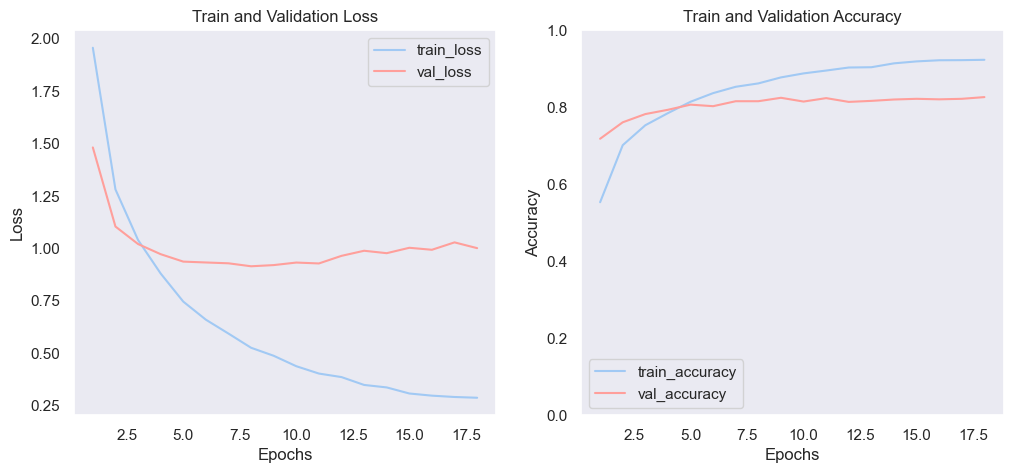

In [39]:
import seaborn as sns
sns.set_theme(style='darkgrid', palette='pastel')

# history 1개 보여주는 그래프
def show_history(history):
    history_dict = history.history
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(12, 5))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b-', label='train_loss')
    ax1.plot(epochs, val_loss, 'r-', label='val_loss')
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()
    
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
    ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')

    ax2.set_ylim(0, 1)
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()
    
    plt.show()

show_history(history)

- 여전히 과대적합이 의심된다.
  - train 정확도는 1에 가까이 올라가는데 그에 비해 val 정확도는 에포크 4부터 크게 늘어나지 않는다.

---

### model2 
- model1에 L2 규제 추가

In [34]:
# model2
'''
dropout: 50%
he_uniform initializer
batch normalization
L2 regularization
Adam - learning rate : 0.001
'''
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000,), kernel_initializer='he_uniform', 
                       kernel_regularizer='l2'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, kernel_initializer='he_uniform',
                      kernel_regularizer='l2'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [35]:
# train
history2 = model.fit(x_train, y_train, epochs=60, 
                    validation_data=(x_val, y_val), callbacks=[check_point_cb, early_stop])

Epoch 1/60
211/211 [==============================] - 1s 4ms/step - loss: 4.7012 - accuracy: 0.5491 - val_loss: 3.9358 - val_accuracy: 0.7008
Epoch 2/60
211/211 [==============================] - 1s 4ms/step - loss: 2.9661 - accuracy: 0.7049 - val_loss: 2.6798 - val_accuracy: 0.7516
Epoch 3/60
211/211 [==============================] - 1s 3ms/step - loss: 2.4002 - accuracy: 0.7457 - val_loss: 2.3276 - val_accuracy: 0.7774
Epoch 4/60
211/211 [==============================] - 1s 3ms/step - loss: 2.1654 - accuracy: 0.7628 - val_loss: 2.1161 - val_accuracy: 0.7890
Epoch 5/60
211/211 [==============================] - 1s 3ms/step - loss: 2.0500 - accuracy: 0.7801 - val_loss: 2.1135 - val_accuracy: 0.7876
Epoch 6/60
211/211 [==============================] - 1s 3ms/step - loss: 2.0142 - accuracy: 0.7870 - val_loss: 2.1248 - val_accuracy: 0.7965
Epoch 7/60
211/211 [==============================] - 1s 3ms/step - loss: 2.0038 - accuracy: 0.7960 - val_loss: 2.1212 - val_accuracy: 0.7943
Epoch 

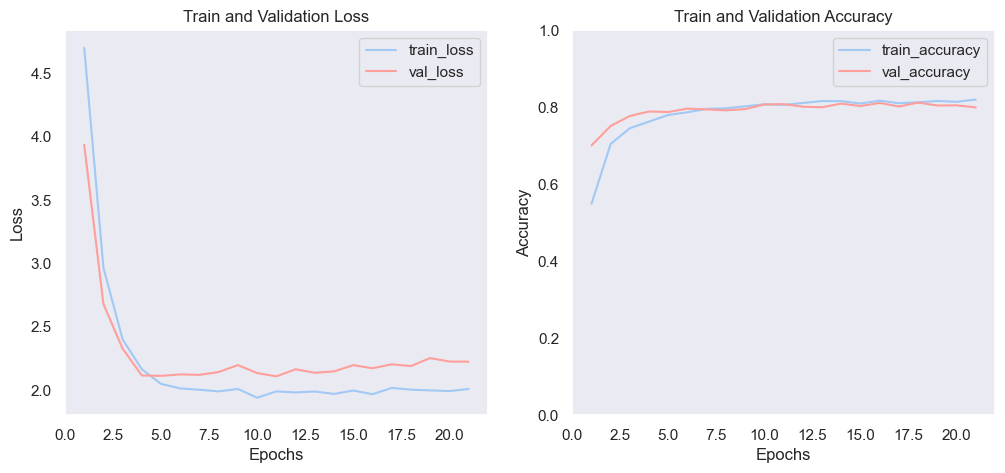

In [40]:
show_history(history2)

In [45]:
# history 2개 비교 함수
def compare_history(history, history2):
    history_dict = history.history
    history2_dict = history2.history

    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    second_loss = history2_dict['loss']
    second_val_loss = history2_dict['val_loss']

    # Determine the number of epochs based on the shorter history
    epochs = range(1, min(len(loss), len(second_loss)) + 1)
    
    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, second_loss[:len(epochs)], 'b-', label='model2 train_loss')
    ax1.plot(epochs, second_val_loss[:len(epochs)], 'r-', label='model2 val_loss')
    ax1.plot(epochs, loss[:len(epochs)], 'b--', label='model1 train_loss')
    ax1.plot(epochs, val_loss[:len(epochs)], 'r--', label='model1 val_loss')

    ax1.set_ylim(min(min(loss), min(second_loss)), max(max(loss), max(second_loss)))
    ax1.set_title('Train and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    second_accuracy = history2_dict['accuracy']
    second_val_accuracy = history2_dict['val_accuracy']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, second_accuracy[:len(epochs)], 'b-', label='model2 train_accuracy')
    ax2.plot(epochs, second_val_accuracy[:len(epochs)], 'r-', label='model2 val_accuracy')
    ax2.plot(epochs, accuracy[:len(epochs)], 'b--', label='model1 train_accuracy')
    ax2.plot(epochs, val_accuracy[:len(epochs)], 'r--', label='model1 val_accuracy')

    # Set y-axis limits for accuracy plots
    ax2.set_ylim(0, 1)
    
    ax2.set_title('Train and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()


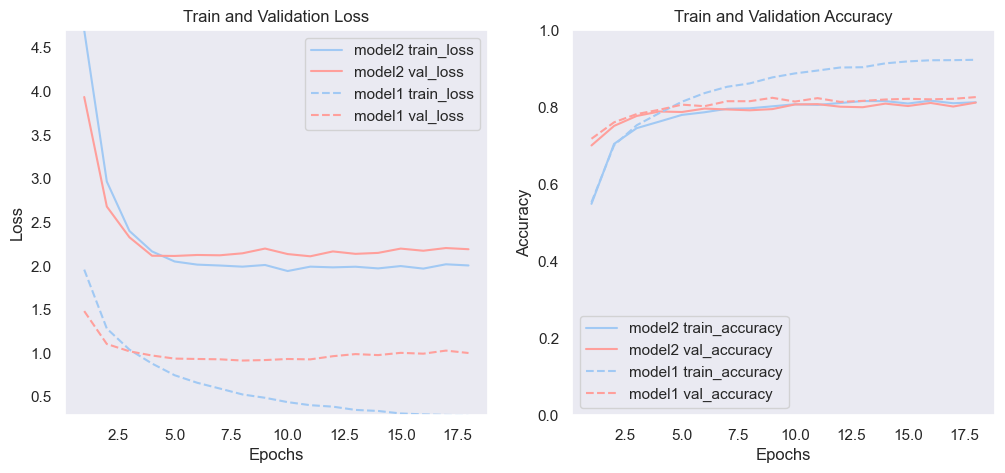

In [46]:
compare_history(history, history2)

- 모델1에 비해 loss 값은 커졌지만 과대적합은 막은것으로 보인다.
- 그럼 층을 조금 더 깊게 만들어서 학습을 조금더 하도록 수정해야겠다

---

### Model 3 - Deeper model2

In [47]:
# model 3
'''
dropout: 50%
he_uniform initializer
batch normalization
L2 regularization
Adam - learning rate : 0.001
'''
model = models.Sequential()
model.add(layers.Dense(512, input_shape=(10000,), kernel_initializer='he_uniform', 
                       kernel_regularizer='l2'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, kernel_initializer='he_uniform',
                      kernel_regularizer='l2'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, kernel_initializer='he_uniform',
                      kernel_regularizer='l2'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(46, activation='softmax'))

adam = optimizers.legacy.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [48]:
# train
history3 = model.fit(x_train, y_train, epochs=60, 
                    validation_data=(x_val, y_val), callbacks=[check_point_cb, early_stop])

Epoch 1/60
211/211 [==============================] - 3s 14ms/step - loss: 9.8970 - accuracy: 0.5456 - val_loss: 7.1177 - val_accuracy: 0.6621
Epoch 2/60
211/211 [==============================] - 3s 13ms/step - loss: 5.2561 - accuracy: 0.6851 - val_loss: 4.3789 - val_accuracy: 0.7289
Epoch 3/60
211/211 [==============================] - 3s 13ms/step - loss: 3.8848 - accuracy: 0.7245 - val_loss: 3.8263 - val_accuracy: 0.7440
Epoch 4/60
211/211 [==============================] - 3s 12ms/step - loss: 3.5680 - accuracy: 0.7384 - val_loss: 3.4946 - val_accuracy: 0.7645
Epoch 5/60
211/211 [==============================] - 3s 13ms/step - loss: 3.4174 - accuracy: 0.7452 - val_loss: 3.4671 - val_accuracy: 0.7689
Epoch 6/60
211/211 [==============================] - 3s 14ms/step - loss: 3.3509 - accuracy: 0.7534 - val_loss: 3.4632 - val_accuracy: 0.7671
Epoch 7/60
211/211 [==============================] - 2s 12ms/step - loss: 3.3744 - accuracy: 0.7531 - val_loss: 3.5180 - val_accuracy: 0.7569

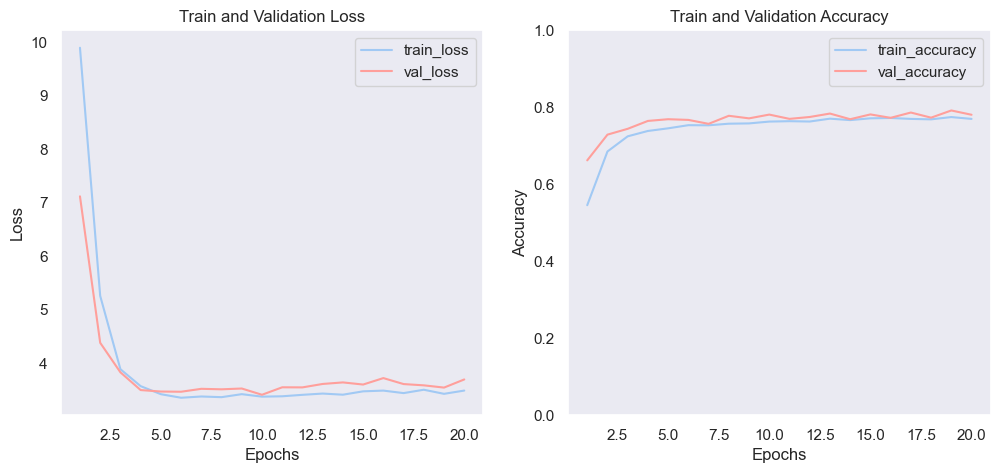

In [49]:
show_history(history3)

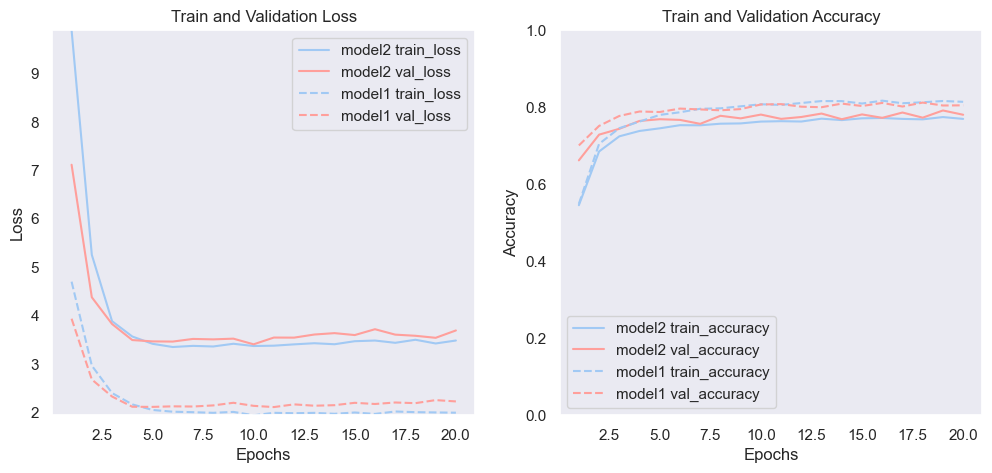

In [50]:
compare_history(history2, history3)

- 과대적합 막는 옵션이 너무 강한가보다.. 손실값은 model2가 더 낮고, 정확도 값은 거의 비슷하다.
- ~3번째 과제를 해보고 추가 모델 수정을 해야겠다.~ 시간이 늦어져서 주말을 기약해본다!